In [1]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output, State

import pandas as pd
import math
import numpy as np
import plotly.graph_objs as go

from scipy.spatial.distance import cityblock
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import chebyshev
import itertools

import xgboost

import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import Isomap
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from collections import defaultdict
from collections import Counter

import pickle

In [2]:
import pandas as pd
import numpy as np
import itertools
from numba import njit, jit

"""
------------------------------------------
General SHAP computation helper functions.
------------------------------------------
"""

@njit
def find_index(array, item):
    """
    Accelerated index finder.
    """
    for idx, val in np.ndenumerate(array):
        if val == item:
            return idx[0]

def computeb1b2(x, w, o, i, pre_idx, order=-1, prng=None):
    """
    Compute b1 and b2 for order sample o, instance sample w, and feature index i.
    
    Parameters
    ----------
    w : numpy array
        array of size n with feature values of instance (w)
    o : numpy array 
        array of size n with order of features
    i : int
        feature index
    pre_idx : numpy array
        arrangement of feature indices
    """
    pos_i = find_index(o, i) # pos_i = np.where(o == i)[0][0]
    idx = pre_idx[pos_i + 1:] # positions succeeding i 
    o_idx = o[idx] # features succeeding i
    b1 = x.copy()
    b1[o_idx] = w[o_idx] # fill features succeeding i with w
    b2 = b1.copy()
    b2[i] = w[i] # change x_i to w_i    
    return b1, b2

"""
-----------------------------------
Exact computation helper functions.
-----------------------------------
"""

def retrieve_instances(mc, X):
    """
    Retrieve all 
    """
    if mc == 'uniform-cat':
        z = [X[c].unique() for c in X.columns]
        instances = list(itertools.product(*z))
    elif mc == 'training':
        instances = X.as_matrix()
    return instances

def retrieve_permutations(n):
    permutations = list(itertools.permutations(range(n)))
    return permutations

"""
-----------------------------------
Adaptive Sampling helper functions.
-----------------------------------
"""
def update(existingAggregate, newValue):
    """
    Update the count, mean, and mean square.
    
    Welford's online algorithm for calculating variance.
    
    existingAggretate : tuple
        (count, mean, M2)
    newValue : float
        f(b1) - f(b2) for newest sample
    """
    (count, mean, M2) = existingAggregate
    count += 1 
    delta = newValue - mean
    mean += delta / count
    delta2 = newValue - mean
    M2 += delta * delta2
    sampleVariance = M2/(count - 1)
    return count, mean, M2, sampleVariance

"""
-------------
SHAP classes.
-------------
"""

class Generator:
    """
    Generator for instaces (w)
    """
    def __init__(self, X, mc):
        """
        Paramaters
        ----------
        X : pandas DataFrame
            Training data for sampling instances (w)
        mc : string
            - 'training' : sample instances (w) from training data
        """
        self.mc = mc
        self.feature_generators = {}
        self.columns = X.columns.tolist()
        if mc == 'training':
            self.X = X
        else: 
            raise ValueError("'%s' is an invalid Monte Carlo sampling strategy." % self.mc)
        return

    def sample(self, n, seed = 1, sample_type = 'dict', replace = True):
        """
        Sample n ranodm instances (w).
        Parameters
        ----------
        n : int
            number of samples
        seed : int
            pseudorandom seed
        replacement : Boolean
            sample with replacement (True) or without replacement (False)
        Returns
        -------
        samples : numpy array
            two dimensional numpy array of feature * instances
        """
        if self.mc == 'training':
            samples = self.X.sample(n = n, random_state = seed, replace = replace)
        return samples

class Values:
    """
    Store SHAP values and samples.
    """
    def __init__(self, shap_values, abs_shap_values, samples = None):
        self.shap_values = shap_values
        self.abs_shap_values = abs_shap_values
        self.samples = samples
        return

class Explainer:
    """
    Object that can be called to compute SHAP values. Stores training data, classifier and sampling parameter.
    """

    def __init__(self, X, mc = 'training', f = None):
        """
        Paramaters
        ----------
        X : pandas DataFrame
            Training data for sampling instances (w)
        mc : string
            - 'training' : sample instances (w) from training data
        """
        self.X = X
        self.mc = mc
        self.f = f
        return

    def standard(self, x, m, f = None, X = None, mc = None, seed = 1, verbose = False, return_samples=False):

        """
        Naive Monte Carlo approximation of SHAP values.
        
        Parameters
        ----------
        x : numpy array
            numpy array containing all feature values, features must be ordered according to dataframe
        f : object
            model should have function '.predict_proba()' that takes as input an instance and as 
            output a probability for the positive class
        m : int
            number of samples for each feature
        X : pandas DataFrame
            training dataset
        mc : string
            Monte Carlo sampling strategy that indicates how random instances are sampled.
            The sampling strategy affects the computation of the conditional expectation.
            'training' : random instances will be sampled from the training data
        seed : int
            seed used for generating random instances and choosing random orders
        verbose : Boolean
            controls verbosity
        return_samples : Boolean
            returning samples that were used to commpute SHAP values to allow for SHAP-ICE and SHAP-ICC plots.
        """

        # Retrieve explainer variables
        X, mc, f = self.X, self.mc, self.f
        
        # Initialize vars
        features = np.arange(len(X.columns)).astype(int) # numpy array with feature indexes
        n = len(features)
        chi = Generator(X=X, mc=mc)
        phi = {}
        abs_phi = {}
        pre_idx = np.arange(len(features)) 

        # Sample all permutations (o)
        prng = np.random.RandomState(seed=seed)
        permutations = [prng.permutation(range(n)) for i in range(m*n)]
        
        # Sample all instances (w)
        samples = np.array(chi.sample(n=m*n, seed=seed, sample_type = 'array'))
        
        #TEMP
        temp_results = {}
        
        # Compute all b1 and b2
        b1_all = [0]*(m*n) # initialize list with all b1's
        b2_all = [0]*(m*n) # initialize list with all b2's
        for i, index_n in zip(features, range(n)): # for each feature
            temp_feature_results = []
            for w, o, index_m in zip(samples[index_n*m:(index_n+1)*m], permutations[index_n*m:(index_n+1)*m], range(m)):
                # for each sample index_m, consisting of instance w and order o:
                b1, b2 = computeb1b2(x, w, o, i, pre_idx)
                all_index = index_n*m + index_m
                b1_all[all_index] = b1
                b2_all[all_index] = b2
                # TEMP
                temp_feature_results.append({'o' : tuple(o), 'w' : w, 'b1' : b1, 'b2' : b2, 'v' : w[i]})
            temp_results[i] = pd.DataFrame(temp_feature_results)

        # Make predictions for instances b1 and b2
        predictions = np.array(f.predict_proba(b1_all + b2_all))[:, 1]
        if verbose:
            print("Average predictions b1/b2: %.5f" %(np.mean(predictions)))

        # Compute Shapley value based on marginal contributions
        for i, j in zip(X.columns, features):
            b1_i = predictions[(j*m):(j+1)*m]
            b2_i = predictions[(n*m+j*m):(n*m+(j+1)*m)]
            phi[i] = sum(b1_i-b2_i)/m
            abs_phi[i] = sum([abs(diff) for diff in (b1_i-b2_i)])/m
            
            # TEMP
            temp_results[j]['f(b1)'] = b1_i
            temp_results[j]['f(b2)'] = b2_i
            temp_results[j]['c'] = b1_i - b2_i
        if return_samples:
            return Values(phi, abs_phi, samples = temp_results)
        else:
            return Values(phi, abs_phi)

In [3]:
def label_encode(df, cat_variables):
    dataframe = df.copy()
    label_dictionary = defaultdict(LabelEncoder)
    dataframe[cat_variables] = dataframe[cat_variables].apply(lambda x: label_dictionary[x.name].fit_transform(x))
    return dataframe, label_dictionary


def label_decode(df, cat_variables, label_dictionary):
    dataframe = df.copy()
    dataframe[cat_variables] = dataframe[cat_variables].apply(lambda x: label_dictionary[x.name].inverse_transform(x))
    return dataframe


def label_encode_new(df, cat_variables, label_dictionary):
    dataframe = df.copy()
    dataframe[cat_variables] = dataframe[cat_variables].apply(lambda x: label_dictionary[x.name].transform(x))
    return dataframe

In [4]:
X, y = shap.datasets.adult(display=True)

X['TF'] = y
X = X[(X[X.columns] != ' ?').all(axis=1)]
X.reset_index(drop=True, inplace=True)
X.drop_duplicates(inplace=True)
X, y = X.loc[:, X.columns != 'TF'], X['TF']
y = np.array(y)

num_features = ['Age', 'Education-Num', 'Capital Gain', 'Capital Loss', 'Hours per week']
cat_features = ['Workclass', 'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country']

# convert float to int
X['Education-Num'] = X['Education-Num'].astype(int)
X['Age'] = X['Age'].astype(int)
X['Hours per week'] = X['Hours per week'].astype(int)

X_enc, encode_dict = label_encode(X, cat_features)
y_enc = y

X_train, X_test, y_train, y_test = train_test_split(X_enc, y_enc, train_size=6000, test_size=2000, random_state=7)
X_train_a, X_train_b, y_train_a, y_train_b = train_test_split(X_train, y_train, train_size=4000, test_size=2000, random_state=7)
# X_train_display, X_test_display, y_train_display, y_test_display = train_test_split(X, y, train_size=2000, test_size=500,
#                                                                                     random_state=7)

C:\Users\20174999\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [5]:
model = GaussianNB()
model.fit(X_train_a, y_train_a)

GaussianNB(priors=None, var_smoothing=1e-09)

In [6]:
y_pred_train = model.predict_proba(X_train)[:,1]
y_pred_tf_train = (y_pred_train >= 0.5)


auc_score = roc_auc_score(y_train, y_pred_train)
print("ROC AUC score:", auc_score)

ROC AUC score: 0.8481185481481877


In [7]:
y_pred_tf_train.shape

(6000,)

In [8]:
confusion_matrix = []

for i in range(0, len(y_train)):
    if y_train[i] == True and y_pred_tf_train[i] == True:
        confusion_matrix.append("TP")
    elif y_train[i] == False and y_pred_tf_train[i] == False:
        confusion_matrix.append("TN")
    elif y_train[i] == False and y_pred_tf_train[i] == True:
        confusion_matrix.append("FP")
    else:
        confusion_matrix.append("FN")

In [9]:
explainer = Explainer(X = X_train, f = model)

In [10]:
shap_train = np.empty((0, len(X.columns)))
for i in range(0, len(X_train.index)):
    values = explainer.standard(x=np.asarray(X_train.iloc[i]), m=100, return_samples=True)
    shap_train = np.append(shap_train, [list(values.shap_values.values())], axis=0)

In [11]:
shap_test = np.empty((0, len(X.columns)))
for i in range(0, len(X_test.index)):
    values = explainer.standard(x=np.asarray(X_test.iloc[i]), m=100, return_samples=True)
    shap_test = np.append(shap_test, [list(values.shap_values.values())], axis=0)

In [12]:
neighbors = NearestNeighbors(n_neighbors=20, metric='euclidean')
neighbors.fit(shap_train)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
         metric_params=None, n_jobs=None, n_neighbors=20, p=2, radius=1.0)

In [13]:
train_neighbor_distance, train_neighbor_index = neighbors.kneighbors(shap_test, n_neighbors=20, return_distance=True)

In [14]:
TS = []

for j in range(0, len(train_neighbor_distance)):
    total_dist = 0
    dist = 0
    for i in range(0, len(train_neighbor_index[j])):
        test_index = train_neighbor_index[j][i]
        test_distance = train_neighbor_distance[j][i]
        if train_neighbor_distance[j][i] == 0.0:
            test_distance = np.min(train_neighbor_distance[j][0:][np.nonzero(train_neighbor_distance[j][0:])])
        if confusion_matrix[test_index] == 'TP':
            #print("TP")
            total_dist = total_dist + (1/test_distance)
            dist = dist + (1/test_distance)
        elif confusion_matrix[test_index] == 'TN':
            #print("TN")
            total_dist = total_dist + (1/test_distance)
            dist = dist + (1/test_distance)
        elif confusion_matrix[test_index] == 'FP':
            #print("FP")
            total_dist = total_dist + (1/test_distance)
        else:
            #print("FN")
            total_dist = total_dist + (1/test_distance)
    score = dist/total_dist
    TS.append(score)

In [15]:
TS_2 = []

for j in range(0, len(train_neighbor_distance)):
    total_dist = 0
    dist = 0
    for i in range(0, len(train_neighbor_index[j])):
        test_index = train_neighbor_index[j][i]
        #print(train_neighbor_distance[j][i])
        if confusion_matrix[test_index] == 'TP':
            #print("TP")
            #total_dist = total_dist + (1/train_neighbor_distance[j][i]) if not math.isnan(train_neighbor_distance[j][i]) else total_dist + (1/np.min(train_neighbor_distance[j][0:]))
            #dist = dist + (1/train_neighbor_distance[j][i]) if not math.isnan(train_neighbor_distance[j][i]) else dist + (1/np.min(train_neighbor_distance[j][0:]))
            dist = dist + (-train_neighbor_distance[j][i])
            total_dist = total_dist + (-train_neighbor_distance[j][i])
        elif confusion_matrix[test_index] == 'TN':
            #print("TN")
            #total_dist = total_dist + (1/train_neighbor_distance[j][i]) if not math.isnan(train_neighbor_distance[j][i]) else total_dist + (1/np.min(train_neighbor_distance[j][0:]))
            #dist = dist + (1/train_neighbor_distance[j][i]) if not math.isnan(train_neighbor_distance[j][i]) else dist + (1/np.min(train_neighbor_distance[j][0:]))
            dist = dist + (-train_neighbor_distance[j][i])
            total_dist = total_dist + (-train_neighbor_distance[j][i])
        elif confusion_matrix[test_index] == 'FP':
            #print("FP")
            #total_dist = total_dist + (1/train_neighbor_distance[j][i]) if not math.isnan(train_neighbor_distance[j][i]) else total_dist + (1/np.min(train_neighbor_distance[j][0:]))
            total_dist = total_dist + (-train_neighbor_distance[j][i])
        else:
            #print("FN")
            #total_dist = total_dist + (1/train_neighbor_distance[j][i]) if not math.isnan(train_neighbor_distance[j][i]) else total_dist + (1/np.min(train_neighbor_distance[j][0:]))
            total_dist = total_dist + (-train_neighbor_distance[j][i])
    score = dist/total_dist if not math.isnan(dist/total_dist) else 0.5
    TS_2.append(score)

In [16]:
TS_3 = []

for j in range(0, len(train_neighbor_distance)):
    total_dist = 0
    dist = 0
    for i in range(0, len(train_neighbor_index[j])):
        test_index = train_neighbor_index[j][i]
        #print(train_neighbor_distance[j][i])
        if confusion_matrix[test_index] == 'TP':
            #print("TP")
            #total_dist = total_dist + (1/train_neighbor_distance[j][i]) if not math.isnan(train_neighbor_distance[j][i]) else total_dist + (1/np.min(train_neighbor_distance[j][0:]))
            #dist = dist + (1/train_neighbor_distance[j][i]) if not math.isnan(train_neighbor_distance[j][i]) else dist + (1/np.min(train_neighbor_distance[j][0:]))
            dist = dist + (-train_neighbor_distance[j][i])
            #total_dist = total_dist + (train_neighbor_distance[j][i])
        elif confusion_matrix[test_index] == 'TN':
            #print("TN")
            #total_dist = total_dist + (1/train_neighbor_distance[j][i]) if not math.isnan(train_neighbor_distance[j][i]) else total_dist + (1/np.min(train_neighbor_distance[j][0:]))
            #dist = dist + (1/train_neighbor_distance[j][i]) if not math.isnan(train_neighbor_distance[j][i]) else dist + (1/np.min(train_neighbor_distance[j][0:]))
            dist = dist + (-train_neighbor_distance[j][i])
            #total_dist = total_dist + (train_neighbor_distance[j][i])
        #elif confusion_matrix[test_index] == 'FP':
            #print("FP")
            #total_dist = total_dist + (1/train_neighbor_distance[j][i]) if not math.isnan(train_neighbor_distance[j][i]) else total_dist + (1/np.min(train_neighbor_distance[j][0:]))
            #total_dist = total_dist + (train_neighbor_distance[j][i])
        #else:
            
            #print("FN")
            #total_dist = total_dist + (1/train_neighbor_distance[j][i]) if not math.isnan(train_neighbor_distance[j][i]) else total_dist + (1/np.min(train_neighbor_distance[j][0:]))
            #total_dist = total_dist + (train_neighbor_distance[j][i])
    #score = dist/total_dist if not math.isnan(dist/total_dist) else 0.5
    score = dist
    TS_3.append(score)

In [17]:
TS_4 = []

for j in range(0, len(train_neighbor_distance)):
    total_dist = 0
    dist = 0
    for i in range(0, len(train_neighbor_index[j])):
        test_index = train_neighbor_index[j][i]
        #print(train_neighbor_distance[j][i])
        if confusion_matrix[test_index] == 'TP':
            #print("TP")
            #total_dist = total_dist + (1/train_neighbor_distance[j][i]) if not math.isnan(train_neighbor_distance[j][i]) else total_dist + (1/np.min(train_neighbor_distance[j][0:]))
            dist = dist + (1/train_neighbor_distance[j][i]) if not math.isnan(train_neighbor_distance[j][i]) else dist + (1/np.min(train_neighbor_distance[j][0:]))
        elif confusion_matrix[test_index] == 'TN':
            #print("TN")
            #total_dist = total_dist + (1/train_neighbor_distance[j][i]) if not math.isnan(train_neighbor_distance[j][i]) else total_dist + (1/np.min(train_neighbor_distance[j][0:]))
            dist = dist + (1/train_neighbor_distance[j][i]) if not math.isnan(train_neighbor_distance[j][i]) else dist + (1/np.min(train_neighbor_distance[j][0:]))
        #elif confusion_matrix[test_index] == 'FP':
            #print("FP")
            #total_dist = total_dist + (1/train_neighbor_distance[j][i]) if not math.isnan(train_neighbor_distance[j][i]) else total_dist + (1/np.min(train_neighbor_distance[j][0:]))
        #else:
            #print("FN")
            #total_dist = total_dist + (1/train_neighbor_distance[j][i]) if not math.isnan(train_neighbor_distance[j][i]) else total_dist + (1/np.min(train_neighbor_distance[j][0:]))
    #score = dist/total_dist if not math.isnan(dist/total_dist) else 0.5
    TS_4.append(dist)

C:\Users\20174999\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in double_scalars



In [18]:
np.shape(TS)

(2000,)

In [19]:
b = True if True in np.isnan(np.array(TS)) else False
print(b)

False


In [31]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.cm as cm
from sklearn.metrics import precision_recall_curve
#import tensorflow as tf

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier


def run_logistic(X_train, y_train, X_test, y_test, get_training=False):
  model = LogisticRegression()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  all_confidence = model.predict_proba(X_test)
  confidences = all_confidence[range(len(y_pred)), y_pred]
  if not get_training:
    return y_pred, confidences
  y_pred_training = model.predict(X_train)
  all_confidence_training = model.predict_proba(X_train)
  confidence_training = all_confidence_training[range(len(y_pred_training)),
                                                y_pred_training]
  return y_pred, confidences, y_pred_training, confidence_training


def run_linear_svc(X_train, y_train, X_test, y_test, get_training=False):
  model = LinearSVC()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  all_confidence = model.decision_function(X_test)
  confidences = all_confidence[range(len(y_pred)), y_pred]
  if not get_training:
    return y_pred, confidences
  y_pred_training = model.predict(X_train)
  all_confidence_training = model.decision_function(X_train)
  confidence_training = all_confidence_training[range(len(y_pred_training)),
                                                y_pred_training]
  return y_pred, confidences, y_pred_training, confidence_training


def run_random_forest(X_train, y_train, X_test, y_test, get_training=False):
  model = RandomForestClassifier()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  all_confidence = model.predict_proba(X_test)
  confidences = all_confidence[range(len(y_pred)), y_pred]
  if not get_training:
    return y_pred, confidences
  y_pred_training = model.predict(X_train)
  all_confidence_training = model.predict_proba(X_train)
  confidence_training = all_confidence_training[range(len(y_pred_training)),
                                                y_pred_training]
  return y_pred, confidences, y_pred_training, confidence_training


# def run_simple_NN(X,
#                   y,
#                   X_test,
#                   y_test,
#                   num_iter=10000,
#                   hidden_units=100,
#                   learning_rate=0.05,
#                   batch_size=100,
#                   display_steps=1000,
#                   n_layers=1,
#                   get_training=False):
#   """Run a NN with a single layer on some data.
#   Returns the predicted values as well as the confidences.
#   """
#   n_labels = np.max(y) + 1
#   n_features = X.shape[1]

#   x = tf.placeholder(tf.float32, [None, n_features])
#   y_ = tf.placeholder(tf.float32, [None, n_labels])

#   def simple_NN(input_placeholder, n_layers):

#     W_in = weight_variable([n_features, hidden_units])
#     b_in = bias_variable([hidden_units])
#     W_mid = [
#         weight_variable([hidden_units, hidden_units])
#         for i in range(n_layers - 1)
#     ]
#     b_mid = [bias_variable([hidden_units]) for i in range(n_layers - 1)]
#     W_out = weight_variable([hidden_units, n_labels])
#     b_out = bias_variable([n_labels])

#     layers = [tf.nn.relu(tf.matmul(input_placeholder, W_in) + b_in)]
#     for i in range(n_layers - 1):
#       layer = tf.nn.relu(tf.matmul(layers[-1], W_mid[i]) + b_mid[i])
#       layers.append(layer)

#     logits = tf.matmul(layers[-1], W_out) + b_out
#     return logits

#   NN_logits = simple_NN(x, n_layers)

#   cross_entropy = tf.reduce_mean(
#       tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=NN_logits))
#   train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
#   correct_prediction = tf.equal(tf.argmax(NN_logits, 1), tf.argmax(y_, 1))
#   accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#   def one_hot(ns):
#     return np.eye(n_labels)[ns]

#   y_onehot = one_hot(y)
#   y_test_onehot = one_hot(y_test)

#   with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     for i in range(num_iter):
#       ns = np.random.randint(0, len(X), size=batch_size)
#       if (i + 1) % display_steps == 0:
#         train_accuracy = accuracy.eval(feed_dict={x: X, y_: y_onehot})
#         test_accuracy = accuracy.eval(feed_dict={x: X_test, y_: y_test_onehot})

#         print("step %d, training accuracy %g, test accuracy %g" %
#               (i + 1, train_accuracy, test_accuracy))
#       train_step.run(feed_dict={x: X[ns, :], y_: y_onehot[ns, :]})

#     testing_logits = NN_logits.eval(feed_dict={x: X_test})
#     testing_prediction = tf.argmax(NN_logits, 1).eval(feed_dict={x: X_test})
#     NN_softmax = tf.nn.softmax(NN_logits).eval(feed_dict={x: X_test})
#     testing_confidence_raw = tf.reduce_max(NN_softmax,
#                                            1).eval(feed_dict={x: X_test})

#     if not get_training:
#       return testing_prediction, testing_confidence_raw
#     training_prediction = tf.argmax(NN_logits, 1).eval(feed_dict={x: X})
#     NN_softmax = tf.nn.softmax(NN_logits).eval(feed_dict={x: X})
#     training_confidence_raw = tf.reduce_max(NN_softmax,
#                                             1).eval(feed_dict={x: X})
#     return testing_prediction, testing_confidence_raw, training_prediction, training_confidence_raw


def plot_precision_curve(
    extra_plot_title,
    percentile_levels,
    signal_names,
    final_TPs,
    final_stderrs,
    final_misclassification,
    predict_when_correct,
    model_name="Model",
    colors=["blue", "darkorange", "brown", "red", "purple"],
    legend_loc=None,
    figure_size=(8,6),
    ylim=None):
  if figure_size is not None:
    plt.figure(figsize=figure_size)
  title = "Precision Curve" if extra_plot_title == "" else extra_plot_title
  plt.title(title, fontsize=20)
  colors = colors + list(cm.rainbow(np.linspace(0, 1, len(final_TPs))))

  plt.xlabel("Percentile level", fontsize=18)
  if predict_when_correct:
    plt.ylabel("Accuracy", fontsize=18)
  else:
    plt.ylabel("Misclassification", fontsize=18)
  for i, signal_name in enumerate(signal_names):
    ls = "--" if ("Model" in signal_name) else "-"
    plt.plot(
        percentile_levels, final_TPs[i], ls, c=colors[i], label=signal_name)

    plt.fill_between(
        percentile_levels,
        final_TPs[i] - final_stderrs[i],
        final_TPs[i] + final_stderrs[i],
        color=colors[i],
        alpha=0.1)

  if legend_loc is None:
    if 0. in percentile_levels:
      plt.legend(loc="lower right", fontsize=14)
    else:
      plt.legend(loc="upper left", fontsize=14)
  else:
    if legend_loc == "outside":
      plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", fontsize=14)
    else:
      plt.legend(loc=legend_loc, fontsize=14)
  if ylim is not None:
    plt.ylim(*ylim)
#   model_acc = 100 * (1 - final_misclassification)
#   plt.axvline(x=model_acc, linestyle="dotted", color="black")
  plt.show()

In [32]:
def run_precision_recall_experiment_general(X_train,
                                            y_train,
                                            X_test,
                                            y_test,
                                            percentile_levels,
                                            testing_prediction,
                                            testing_confidence_raw,
                                            test_size=0.5,
                                            extra_plot_title="",
                                            signals=[],
                                            signal_names=[],
                                            predict_when_correct=False,
                                            skip_print=False):

    def get_stderr(L):
        return np.std(L) / np.sqrt(len(L))
    
    testing_confidence_raw = np.array(testing_confidence_raw)
    
    temp_signals = signals
    signals = []
    
    for signal in temp_signals:
        signals.append(np.array(signal))
    

    all_signal_names = ["Model Confidence"] + signal_names
    all_TPs = [[[] for p in percentile_levels] for signal in all_signal_names]
    misclassifications = []
    sign = 1 if predict_when_correct else -1
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
    for train_idx, test_idx in sss.split(X_train, y_train):
#         testing_prediction, testing_confidence_raw = trainer(
#             X_train, y_train, X_test, y_test)
        target_points = np.where(
            testing_prediction == y_test)[0] if predict_when_correct else np.where(
                testing_prediction != y_test)[0]

        final_signals = [testing_confidence_raw]
        for signal in signals:
            final_signals.append(signal)
        
        for p, percentile_level in enumerate(percentile_levels):
            all_high_confidence_points = [
              np.where(sign * signal >= np.percentile(sign * signal, percentile_level))[0]
                for signal in final_signals
            ]
            if 0 in map(len, all_high_confidence_points):
                continue
            TP = [
                len(np.intersect1d(high_confidence_points, target_points)) /
                (1. * len(high_confidence_points))
                for high_confidence_points in all_high_confidence_points
            ]
            for i in range(len(all_signal_names)):
                all_TPs[i][p].append(TP[i])
        misclassifications.append(len(target_points) / (1. * len(X_test)))

    final_TPs = [[] for signal in all_signal_names]
    final_stderrs = [[] for signal in all_signal_names]
    for p, percentile_level in enumerate(percentile_levels):
        for i in range(len(all_signal_names)):
            final_TPs[i].append(np.mean(all_TPs[i][p]))
            final_stderrs[i].append(get_stderr(all_TPs[i][p]))

        if not skip_print:
            print("Precision at percentile", percentile_level)
            ss = ""
            for i, signal_name in enumerate(all_signal_names):
                ss += (signal_name + (": %.4f  " % final_TPs[i][p]))
            print(ss)
            print()

    final_misclassification = np.mean(misclassifications)

    if not skip_print:
        print("Misclassification rate mean/std", np.mean(misclassifications), get_stderr(misclassifications))

    for i in range(len(all_signal_names)):
        final_TPs[i] = np.array(final_TPs[i])
        final_stderrs[i] = np.array(final_stderrs[i])  
    
    plot_precision_curve(extra_plot_title, percentile_levels, all_signal_names, final_TPs, final_stderrs, final_misclassification,
                        legend_loc="outside", predict_when_correct=predict_when_correct)

In [33]:
y_pred = model.predict_proba(X_test)[:,1]
y_pred_tf = (y_pred >= 0.5)


auc_score = roc_auc_score(y_test, y_pred)
print("ROC AUC score : ", auc_score)

acc_score = accuracy_score(y_test, y_pred_tf)
print("Accuracy Score : ", acc_score)

ROC AUC score :  0.8740106537530267
Accuracy Score :  0.7935


In [34]:
all_confidence = model.predict_proba(X_test)

confidence = []
for i in range(len(y_pred)):
    if all_confidence[i][0] > all_confidence[i][1]:
        confidence.append(all_confidence[i][0])
    else:
        confidence.append(all_confidence[i][1])

y_pred = np.array(confidence)

In [35]:
percentile_levels = percentile_levels = [0 + 0.5 * i for i in range(195)]

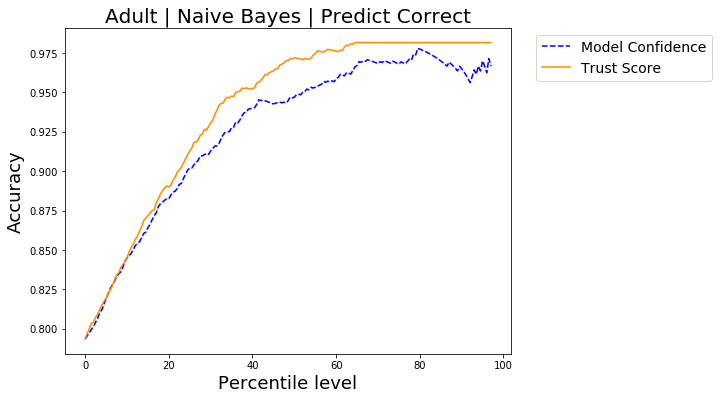

In [36]:
run_precision_recall_experiment_general(X_train = X_train,
                                        y_train = y_train,
                                        X_test = X_test,
                                        y_test = y_test,
                                        percentile_levels = percentile_levels,
                                        testing_prediction = y_pred_tf,
                                        testing_confidence_raw = y_pred,
                                        extra_plot_title="Adult | Naive Bayes | Predict Correct",
                                        signals = [TS],
                                        signal_names = ["Trust Score"],
                                        predict_when_correct=True,
                                        skip_print=True
                                       )

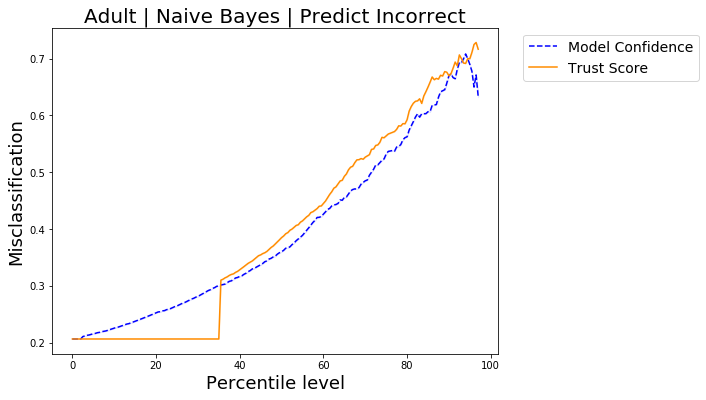

In [37]:
run_precision_recall_experiment_general(X_train = X_train,
                                        y_train = y_train,
                                        X_test = X_test,
                                        y_test = y_test,
                                        percentile_levels = percentile_levels,
                                        testing_prediction = y_pred_tf,
                                        testing_confidence_raw = y_pred,
                                        extra_plot_title="Adult | Naive Bayes | Predict Incorrect",
                                        signals = [TS],
                                        signal_names = ["Trust Score"],
                                        predict_when_correct=False,
                                        skip_print=True
                                       )